# Marcov Chain Monte Carlo for SN Ia

Flat $w$CDM model cosmology

(Domenico Sapone 10/2024)

In [9]:
import matplotlib

import matplotlib.pyplot as plt
import numpy as np

import functools


#import os
#import matplotlib.gridspec as gridspec
#from pylab import setp
#import matplotlib.ticker as ticker

import numpy as np


import math

import scipy 
import scipy.special as ssp
import scipy.integrate as integrate
import scipy.stats as stats
from scipy import interpolate
from scipy.misc import derivative
from scipy.interpolate import interp1d
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy.interpolate import UnivariateSpline

#import sys, platform, os
import time
from math import *


from functools import reduce #python 3
from numpy.linalg import inv


#For C-compilation just in time (requires numba reachable with conda install numba)
#from numba import jit 

interp_type = 'linear' #'cubic'






#from time import time #clock





# Reference Cosmology

In [10]:

#You can take these numbers from any latest paper with constraints on the cosmological parameters
omegabh2ref = 0.02233;
omegach2ref = 0.1198
onuh2ref = 0.00064;
omegamh2ref  = omegabh2ref + omegach2ref + onuh2ref;



href = 0.6766
om0ref = omegamh2ref/href**2

parsin =['h', 'om', 'oml', 'w0', 'w1']
[href, om0ref, oml0ref, w0ref, waref] = [0.6766, om0ref, 1-om0ref, -1, 0]

nparams = 2


#other parameters you might need to convert numbers in "real" numbers

clight = 299792.458 #km/sec



# Hubble parameter

You need to choose your favourite cosmological model, let's start with the non flat DE-CDM model is


\begin{equation}
H(z) = H_0 \sqrt{\Omega_{m,0} (1+z)^3+(1-\Omega_{m,0}-\Omega_{\Lambda,0})(1+z)^2+\Omega_{\Lambda,0}(1+z)^{3(1+w(z))}}
\end{equation}
We may want to make some assumptions at the beginning to speed up calculations and to take under control the possible sources of errors. 

Let's consider $\Lambda$CDM model, i.e. the cosmological constant, this implies:
\begin{equation}
w(z) = -1
\end{equation}
We can also simplify our lifes a bit more and assume flat cosmology, in this case, the Hubble parameter becomes 


\begin{equation}
H(z) = H_0 \sqrt{\Omega_{m,0} (1+z)^3 + (1-\Omega_{m,0}) (1+z)^{3(1+w)}}
\end{equation}

Clearly, now we're left with only one parameter to play with: $\Omega_{m,0}$, because as mentioned and as we will see later $H_0$ cannot be considered as a free parameter. Usually, we have 
\begin{equation}
H_0 = 100\,h\, {\rm Km/s/Mpc}
\end{equation}
and $h$ is the reduced Hubble parameter and it is dimensionless. 

Another function that it is useful is 
\begin{equation}
E(z) = \frac{H(z)}{H_0}
\end{equation}


In [11]:
#def vect_parm(vec):
#    return [vec[ip] for ip in range(0, nparams)]

#def eez(z, vec):
#    [om, oml, w] = vect_parm(vec)
#                  
#    eezi = np.sqrt(om*(1+z)**3. +  (1-om-oml)*(1+z)**2 + oml*(1+z)**(3.*(1+w)))
#                  
#    return eezi
##
#
#def eea(a, vec):
#    # a = 1/(1+z) -> z = 1/a-1
#    return eez(1/a-1, vec)

In [12]:

def eez(z, om, oml, w):                  
    eezi = np.sqrt(om*(1+z)**3. +  (1-om-oml)*(1+z)**2 + oml*(1+z)**(3.*(1+w)))
                  
    return eezi


def eea(a,  om, oml, w):
    # a = 1/(1+z) -> z = 1/a-1
    return eez(1/a-1,  om, oml, w)

# Distance

We need to define the distances. 

The comoving distance to an object at redshift $z$ can be computed as
\begin{equation}
r(z) = \frac{c}{H_0} \int_0^z\frac{{\rm d}x}{E(x)}
\end{equation}
Warning! This is not a direct observable, it is closely related to other distance definitions that are directly linked with cosmological observations. 
For our pourpose we define the angular diameter distant

\begin{eqnarray}
  && \,\,\,\frac{1}{1+z}\frac{c}{H_0}\frac{1}{\sqrt{|\Omega_{k,0}|}}\sin\left(\sqrt{|\Omega_{k,0}|}\frac{H_0}{c}r(z)\right) \hspace{1cm}\text{if }\,\Omega_{K,0} <0\\
D_A(z) \,\,\, &=& \,\,\,\frac{1}{1+z}r(z) \hspace{6.3cm}\text{if }\,\Omega_{K,0} =0\\
&&\,\,\,\frac{1}{1+z}\frac{c}{H_0}\frac{1}{\sqrt{\Omega_{k,0}}}\sinh\left(\sqrt{\Omega_{k,0}}\frac{H_0}{c}r(z)\right) \hspace{1cm}\text{if }\,\Omega_{K,0} >0
\end{eqnarray}

We may want to make some assumptions at the beginning to speed up calculations 
and to take under control the possible sources of errors.

For SNIa we're interested in Luminosity distance: 
\begin{equation}
D_L(z) = (1+z)^2 D_A(z)
\end{equation}

In [13]:
#@functools.lru_cache(maxsize=250)
#@jit(nopython=True)


stepode = 12

#Define the function r(z) 

def r_of_z1(om, oml, w):
    
    zgrid = np.linspace(0, 2., 2**stepode+1)
    

    dz = np.diff(zgrid)[0]
    I1 = np.cumsum(dz/eez(zgrid, om, oml, w))
    interpo = scipy.interpolate.interp1d(zgrid,I1,kind='cubic', fill_value='extrapolate')
    
    return interpo

def r_of_z(z, om, oml, w):
    
    return r_of_z1(om, oml, w)(z)- r_of_z1(om, oml, w)(0)


#Luminosity distance

def distl(z, h, om, oml, w):
    
    omk = 1-om-oml
    cH0 = clight/(100*h)
    if omk==0: distzi= cH0*(1+z)*r_of_z(z, om, oml, w)
    elif omk<0: distzi= cH0*(1+z)/(np.sqrt(abs(omk)))*np.sin(np.sqrt(abs(omk))*r_of_z(z, om, oml, w))
    elif omk>0: distzi= cH0*(1+z)/(np.sqrt(abs(omk)))*np.sinh(np.sqrt(abs(omk))*r_of_z(z, om, oml, w))

    return distzi



def mu_th(z, h, om, oml,w):
    return 5*np.log10(distl(z, h, om, oml, w))

What catalogs really give for SNIa? 

They actually five the lightcurves, i.e. the luminosity of the SN explosion as a function of time. 
However, cosmologist prefer to trust astronomers and we use the "reduced" data, which is called: the distance modulus, defined as
\begin{equation}
\mu(z) = 5 \log \left(D_L(z)\right) + M_0 = 5\log \left(\frac{c}{H_0} d_L(z)\right) + M_0 = 5\log \left(d_L(z)\right)+M_0+5\log\frac{c}{H_0}
\end{equation}
and 
\begin{equation}
\mu(z) = 5\log \left(d_L(z)\right)+\mathcal{M}_0
\end{equation}

There is no way, with SNIa, to measure $H_0$ as it appears as a constant into the equations and it is degenarate with $M_0$. If you calibrate SNIa, i.e. we assume $M_0$ known, than we can infer $H_0$ and we have Riess et al aka tension problem! 

In [14]:

start_time = time.time()
test_time = distl(np.arange(0, 1, 0.001), href, om0ref,1-om0ref, w0ref)
print("--- %s seconds ---" % (time.time() - start_time),test_time)



--- 0.0031223297119140625 seconds --- [0.00000000e+00 4.43375346e+00 8.87428710e+00 1.33215935e+01
 1.77756651e+01 2.22364947e+01 2.67040745e+01 3.11783974e+01
 3.56594557e+01 4.01472421e+01 4.46417491e+01 4.91429694e+01
 5.36508953e+01 5.81655196e+01 6.26868347e+01 6.72148333e+01
 7.17495079e+01 7.62908511e+01 8.08388555e+01 8.53935136e+01
 8.99548181e+01 9.45227614e+01 9.90973363e+01 1.03678535e+02
 1.08266351e+02 1.12860776e+02 1.17461802e+02 1.22069424e+02
 1.26683632e+02 1.31304420e+02 1.35931780e+02 1.40565705e+02
 1.45206187e+02 1.49853220e+02 1.54506795e+02 1.59166905e+02
 1.63833544e+02 1.68506703e+02 1.73186375e+02 1.77872553e+02
 1.82565229e+02 1.87264397e+02 1.91970048e+02 1.96682175e+02
 2.01400771e+02 2.06125829e+02 2.10857341e+02 2.15595301e+02
 2.20339699e+02 2.25090530e+02 2.29847786e+02 2.34611459e+02
 2.39381542e+02 2.44158028e+02 2.48940910e+02 2.53730180e+02
 2.58525831e+02 2.63327855e+02 2.68136245e+02 2.72950995e+02
 2.77772096e+02 2.82599541e+02 2.87433323e+02 2

# Reading data

In order to do MCMC we need to call the data. 

For the MCMC analysis, we need to evaluate the $\chi^2$. 
\begin{equation}
\chi^2 = -\frac12 \sum D^T C^{-1} D
\end{equation}
where D is the data vector defined 
\begin{equation}
D = \mu_i - \mu_{th}(z_i)
\end{equation}
Being $\mu_i$ the data, i.e. your observable and $\mu_{th}(z_i)$ is the theoretical function evaluated that the redshift of your data. 

You can choose whatever catalog you like: I prefer to use the latest one. 

Pantheon catalog comes in a bit weird format. 
It has "lcparam_full_long_zhel.txt" file which contains 
#name zcmb zhel dz mb dmb x1 dx1 color dcolor 3rdvar d3rdvar cov_m_s cov_m_c cov_s_c set ra dec biascor
We're interested in the 2nd, 3rd, 5th and 6th columns. (all the other columns are zeros anyway!) 

The covariance matrix, which containes the varinces and the covarinces of the measured distance moduli are written in a very long column. The first number tells us how many columns the matrix should have and hence how many rows it should also have, hence we need to a partition of the column. 



In [15]:
#The data
mudata1 = np.genfromtxt(r'C:\Users\Julian\Documents\Tareas\Tarea 3 cosmo\sn_data\lcparam_full_long_zhel.txt', dtype = None)
mudata = np.zeros([len(mudata1),4])

#number of data
nsndata = len(mudata)


for i_data in range(len(mudata1)):
    mudata[i_data][0]= mudata1[i_data][1]
    mudata[i_data][1]= mudata1[i_data][2]
    mudata[i_data][2]= mudata1[i_data][4]
    mudata[i_data][3]= mudata1[i_data][5]



#The first number appearing in the covariance list
# which should be exactly equal to the number of data nsndata
ncovdata = int(np.loadtxt(r'C:\Users\Julian\Documents\Tareas\Tarea 3 cosmo\sn_data\sys_full_long.txt', skiprows=0)[0])

#The covariance list
covdata = np.loadtxt(r'C:\Users\Julian\Documents\Tareas\Tarea 3 cosmo\sn_data\sys_full_long.txt', skiprows=1)



# Making the covariance list into a matrix 
covmat = np.zeros([ncovdata, ncovdata])
for icov in range(len(covmat)):
    for jcov in range(len(covmat)):
        covmat[icov][jcov] = covdata[ncovdata*icov:ncovdata*(icov+1)][jcov]
#print(covmat)


#covmat_sys = np.zeros([ncovdata, ncovdata])
#for icov in range(len(covmat_sys)):
#    for jcov in range(len(covmat_sys)):
#        covmat_sys[icov][icov] = mudata[icov, 2]
        

# Systematics in SNIA
covmat_sys = np.diag(mudata[:,3]**2)

unitv = np.ones(nsndata)        

cov_tot = covmat+covmat_sys


invcovtot = inv(cov_tot)


In [16]:
cov_tot

array([[1.60676475e-02, 1.46745000e-04, 9.40700000e-05, ...,
        1.65630000e-04, 1.05605000e-04, 1.49190000e-04],
       [1.46745000e-04, 1.39646125e-02, 8.45400000e-05, ...,
        1.24275000e-04, 6.88900000e-05, 1.09355000e-04],
       [9.40700000e-05, 8.45400000e-05, 4.24441300e-02, ...,
        1.62495000e-04, 2.15960000e-04, 1.85450000e-04],
       ...,
       [1.65630000e-04, 1.24275000e-04, 1.62495000e-04, ...,
        5.32303350e-02, 1.15220000e-03, 8.83200000e-04],
       [1.05605000e-04, 6.88900000e-05, 2.15960000e-04, ...,
        1.15220000e-03, 4.20897450e-02, 1.65156500e-03],
       [1.49190000e-04, 1.09355000e-04, 1.85450000e-04, ...,
        8.83200000e-04, 1.65156500e-03, 7.08746225e-02]])

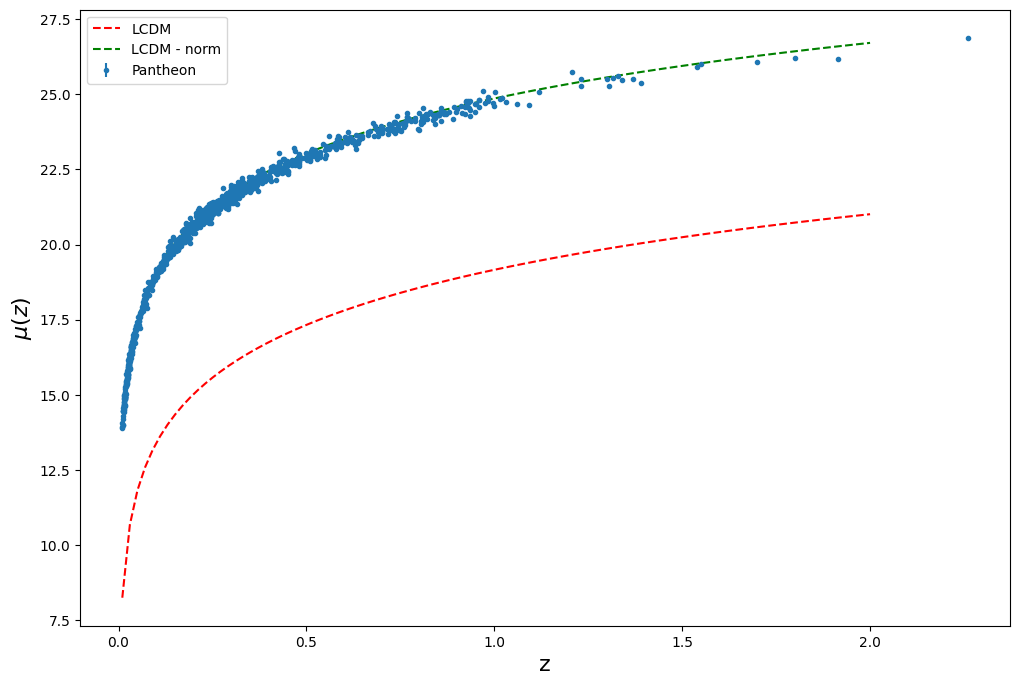

In [17]:
#import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))

zaxe  = np.linspace(0.01,2,100)


mu_th_vec = []
mu_th_vec1 = []

for zi in range(len(zaxe)):
    mu_th_vec.append(mu_th(zaxe[zi], href,  om0ref, 1-om0ref, w0ref))
    mu_th_vec1.append(mu_th(zaxe[zi], href, om0ref, 1-om0ref, w0ref)+5.7)

    
    
#plt.plot(zaxe,hubvecz,'--r', label='Theory') 
plt.plot(zaxe,mu_th_vec,'--r', label='LCDM') 
plt.plot(zaxe,mu_th_vec1,'--g', label='LCDM - norm') 
mudataerr = []
for i in range(len(mudata)):
    mudataerr.append(covmat[i][i])
    
    
plt.errorbar(mudata[:,0], mudata[:,2], yerr=mudataerr[:], fmt='.', label = 'Pantheon')

plt.xlabel('z', size = 16)
plt.ylabel(r'$\mu(z)$',size = 16)

plt.legend()
plt.show()

# $\chi^2$ for SNIa data

We can leave $\mathcal{M}_0$ free and let data infer it. 
For sake of semplicity, let assume we live in a flat universe: $\Omega_{DE,0} = 1-\Omega_{m,0} $ and this automatically assures that $\Omega_{k,0} =0$. 
Remember, we cannot infer $H_0$, so we need to fix it. 

In [18]:

def multi_dot(arrays): 
    return functools.reduce(np.dot, arrays)



def chi2sn(vec):

    deltam = []
    deltam = mudata[:,2]-(vec[0] +5*np.log10((1+mudata[:,1])/(1+mudata[:,0])) + mu_th(mudata[:,0], href, vec[1], 1-vec[1], vec[2]))

    A = multi_dot([deltam,invcovtot,deltam])

    return A 




def chi2tot(vec):
    return chi2sn(vec)







--- 0.006705284118652344 seconds --- 1813.7931079488862


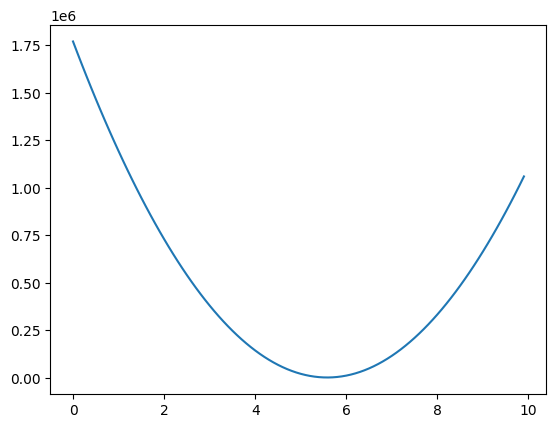

In [19]:
start_time = time.time()
test_time_chi2 = chi2tot([5.7, om0ref, w0ref])
print("--- %s seconds ---" % (time.time() - start_time),test_time_chi2)

m0_range = np.arange(0, 10, 0.1)
chi2_vec = []
for m0_i in range(len(m0_range)):
    chi2_vec.append(chi2tot([m0_range[m0_i], om0ref, w0ref]))
    
plt.plot(m0_range, chi2_vec)

But since we're not really interested in $\mathcal{M}_0$ since it is an astrophysical parameter, 
we can think of marginalizing over it. Marginalization means integrating out, i.e. we want $\mathcal{M}_0$ to desappear. 

The $\chi^2$ belongs to a distribution, i.e. the likelihood: 
\begin{equation}
\mathcal{L} = C \exp\left[-\frac{1}{2}\chi^2\right]
\end{equation}
where $C$ is the normalization constant of the distribution. 

Then we call $\chi^{2}_{\mathcal{M}_0,marg}$, the $\chi^2$ marginalized over $\mathcal{M}_0$. 
Now we need to integrate it over a prior probability of $\pi(\mathcal{M}_0)$, i.e. 
\begin{equation}
\chi^{2}_{\mathcal{M}_0,marg} = -2\ln\left[\int_{-\infty}^{+\infty} d\mathcal{M}_0\exp\left(-\frac12 \chi^2\right)\pi(\mathcal{M}_0)\right]
\end{equation}
The $\chi^2$ is the one seen before, and we rewrite it as
\begin{equation}
\chi^2 = \left(\Delta \vec{m}-\mathcal{M}_0\vec{1}\right)^T C^{-1}\left(\Delta \vec{m}-\mathcal{M}_0\vec{1}\right)
\end{equation}
carrying out the integration we have
\begin{equation}
\chi^{2}_{\mathcal{M}_0,marg} = A + \ln\frac{E}{2\pi} - \frac{B^2}{E}
\end{equation}
being 
\begin{eqnarray}
A &=& \Delta \vec{m}\,^T C^{-1}\Delta \vec{m}\\
B &=& \Delta \vec{m}\,^T C^{-1}\vec{1}\\
E &=& \vec{1}\,^T C^{-1} \vec{1}\\
\Delta \vec{m} &=& \mu_i - 5\log \left(\frac{c}{H_0} d_L(z)\right)
\end{eqnarray}

In [20]:
def chi2sn_m(vec):

    deltam = []

    deltam = mudata[:,2]-5*np.log10((1+mudata[:,1])/(1+mudata[:,0])*distl(mudata[:,0], href, vec[0], 1-vec[0], vec[1]))


    A = multi_dot([deltam, invcovtot, deltam])
    B = multi_dot([deltam, invcovtot, unitv])
    Ee = multi_dot([unitv, invcovtot, unitv])

    return A + np.log(Ee/(2*np.pi)) - B**2/Ee


def chi2tot_m(vec):
    return chi2sn_m(vec)



In [21]:
start_time = time.time()
test_time_chi2_m = chi2tot_m([om0ref, w0ref])
print("--- %s seconds ---" % (time.time() - start_time),test_time_chi2_m)


--- 0.014033079147338867 seconds --- 1035.0738541739993


# MCMC Metropolis-Hastings algorithm 

Metropolis–Hastings and other MCMC algorithms are generally used for sampling from multi-dimensional distributions, especially when the number of dimensions is high. 

The Metropolis–Hastings algorithm can draw samples from any probability distribution $P(x)$, provided that we know a function $f(x)$ proportional to the density of $P$ and the values of $f(x)$ can be calculated. The requirement that $f(x)$ must only be proportional to the density, rather than exactly equal to it, makes the Metropolis–Hastings algorithm particularly useful, because calculating the necessary normalization factor is often extremely difficult in practice.

The purpose of the Metropolis–Hastings algorithm is to generate a collection of states according to a desired distribution $P(x)$. To accomplish this, the algorithm uses a Markov process, which asymptotically reaches a unique stationary distribution $\pi (x)$ such that $\pi (x)=P(x)$.

A Markov process is uniquely defined by its transition probabilities $P(x'\mid x)$, the probability of transitioning from any given state $x$ to any other given state $x'$. It has a unique stationary distribution $\pi (x)$ when the following two conditions are met
- Existence of stationary distribution: there must exist a stationary distribution $\pi (x)$. A sufficient but not necessary condition is detailed balance, which requires that each transition $x\to x'$ is reversible: for every pair of states $x,x'$, the probability of being in state $x$ and transitioning to state $x'$ must be equal to the probability of being in state $x'$ and transitioning to state $x$, $\pi (x)P(x'\mid x)=\pi (x')P(x\mid x')$.
- Uniqueness of stationary distribution: the stationary distribution $\pi (x)$ must be unique. This is guaranteed by ergodicity of the Markov process, which requires that every state must (1) be aperiodic—the system does not return to the same state at fixed intervals; and (2) be positive recurrent—the expected number of steps for returning to the same state is finite.

The Metropolis–Hastings algorithm involves designing a Markov process (by constructing transition probabilities) that fulfills the two above conditions, such that its stationary distribution $\pi (x)$ is chosen to be $P(x)$. The derivation of the algorithm starts with the condition of detailed balance:
\begin{equation}
P(x'\mid x)P(x)=P(x\mid x')P(x')
\end{equation}
which is re-written as
\begin{equation}
\frac {P(x'\mid x)}{P(x\mid x')}=\frac {P(x')}{P(x)}\,.
\end{equation}
The approach is to separate the transition in two sub-steps; the proposal and the acceptance-rejection. The proposal distribution $g(x'\mid x)$ is the conditional probability of proposing a state $x'$ given $x$, and the acceptance ratio $A(x',x)$ is the probability to accept the proposed state $x'$. The transition probability can be written as the product of them:
\begin{equation}
P(x'\mid x)=g(x'\mid x)A(x',x)\,.
\end{equation}
Inserting this relation in the previous equation, we have
\begin{equation}
\frac {A(x',x)}{A(x,x')}=\frac {P(x')}{P(x)}\frac {g(x\mid x')}{g(x'\mid x)}
\end{equation}
The next step in the derivation is to choose an acceptance ratio that fulfills the condition above. One common choice is the Metropolis choice:
\begin{equation}
A(x',x)=\min \left(1,\frac {P(x')}{P(x)}\frac {g(x\mid x')}{g(x'\mid x)}\right)\,.
\end{equation}
For this Metropolis acceptance ratio $A$, either $A(x',x)=1$ or $A(x,x')=1$ and, either way, the condition is satisfied.

The Metropolis–Hastings algorithm thus consists in the following:
- Initialise
    - Pick an initial state $x_{0}$.
    - Set $t=0$.
- Iterate
    - Generate a random candidate state $x'$ according to $g(x'\mid x_{t})$.
    - Calculate the acceptance probability $A(x',x_{t})=\min \left(1,\frac {P(x')}{P(x_{t})}\frac {g(x_{t}\mid x')}{g(x'\mid x_{t})}\right)$.
    - Accept or reject: generate a uniform random number $u\in [0,1]$;
    - if $u\leq A(x',x_{t})$, then accept the new state and set $x_{t+1}=x'$;
    - if $u>A(x',x_{t})$, then reject the new state, and copy the old state forward $x_{t+1}=x_{t}$
    - Increment: set $t=t+1$
    

In [22]:
#Building the A function to be compared with the stationary distribution
def compare(chi, a, b):
    initial = chi(b)
    proposed = chi(a)
    ratio = np.exp(-(proposed-initial)/2)
    acceptratio = np.minimum(1,ratio)
    return acceptratio


# Vectors where to store the estimated values 
omvec = []
wvec = []
Chi2_final = []


#Defining the bounds of the parameters: in principle there are no limit, i.e. 
#they can go from -infinity to +infinity. 
#However, since we're doing physics, we can set some bounds. 
ombound = [0.01, 0.99]
wbound = [-2, -0.3]


priors = [ombound, wbound]

initial_point = priors

# Number of iterations, i.e. random walks
N = 10000

#just to know how long the chain takes
start_time = time.time()
#local clearing the vector in case there was an appending before
omvec.clear()
wvec.clear()
Chi2_final.clear()


#defining the random walk vector
random_point = []
for i in range(len(priors)):
    random_point.append(np.random.uniform(initial_point[i][0],initial_point[i][1]))

    
# start the chain 
for i in range(N):
   
    proposed_point = []
    for i in range(len(random_point)):
        proposed_point.append(np.random.normal(random_point[i],np.sqrt(0.00001)))
        # atm, since we don't have any clue on how the parameters are distributed, 
        # we choose a general variance, small but not too small 
        # that's the reason why we will need a second chain


    #think of a betta' way to do this! I would like it to be more automatic.    
    A = priors[0][0] <proposed_point[0]< priors[0][1]
    B = priors[1][0] <proposed_point[1]< priors[1][1]
    
    if A and B:
        alpha_i = compare(chi2tot_m, proposed_point,random_point)
        u = np.random.uniform(0,1)
        
    
        if u <= alpha_i:  # if condition applies
            omvec.append(proposed_point[0])
            wvec.append(proposed_point[1])
          
            Chi2_final.append(chi2tot_m(proposed_point))
            random_point = proposed_point

        else:   
            random_point = random_point


n_accepted = len(omvec)


# Porcentaje de aceptacion de la cadena

timespent = (time.time() - start_time)
print("--- %s seconds ---" % (time.time() - start_time)) 
print('Percentage of acceptance: ' + str(n_accepted/N))


chainfile = np.dstack(([omvec, wvec, Chi2_final]))[0]
M = np.vstack([omvec, wvec])
covariance = np.cov(M)
print(covariance)



--- 120.38642477989197 seconds ---
Percentage of acceptance: 0.9446
[[ 0.00279813 -0.00222182]
 [-0.00222182  0.00894886]]


[0.3118695492730296, -1]
[0.3099503776664628, -1.0316697074380712] 1034.7058048734907


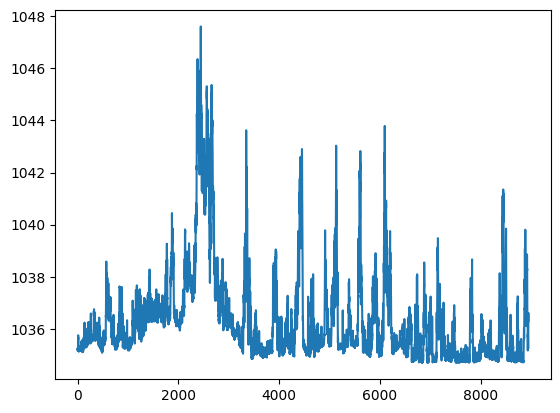

In [23]:
burnin = 500
burnine = -1


chain_values = chainfile[:,-1]
minchi2 = min(chainfile[:,-1])

posmin = [i for i,x in enumerate(chain_values) if x == minchi2][0]
bestfit = [omvec[posmin], wvec[posmin]]
refocsmo = [om0ref,  w0ref]
print(refocsmo)
print(bestfit, minchi2)

plt.plot(Chi2_final[burnin:burnine])


n_sc_not = "{:.0e}".format(N)

np.savetxt(r'C:\Users\Julian\Documents\Tareas\Tarea 3 cosmo\chains\chain_'+str(len(covariance))+'params_flat_first_'+str(n_sc_not)+'_points_pantheon.dat', chainfile, fmt="%s")


### Defining the covariance matrix that will be use in the second random walks process

In [24]:
new_M = M[[0,1], burnin:]
new_covariance = np.cov(new_M)

def err_cov(matrix):
    errtab = []
    for h in range(len(matrix)):
        errtab.append(np.sqrt(matrix[h,h]))
    return errtab

err_chain = err_cov(new_covariance)


In [25]:
err_chain
{bestfit[0]-3*err_chain[0], bestfit[0]-3*err_chain[0]}


{np.float64(0.1806402003234571)}

# First Chain

In [26]:
def compare(chi, a, b):
    initial = chi(b)
    proposed = chi(a)
    ratio = np.exp(-(proposed-initial)/2)
    acceptratio = np.minimum(1,ratio)
    return acceptratio


# Vectors where to store the estimated values 
omvec = []
wvec = []
Chi2_final = []

ombound = [0.01, 0.99]
wbound = [-2, -0.3]




#import uniform

priors = [ombound, wbound]
initial_point = priors

# In case we're really sure that the values found in the first chain are the correct ones, 
# we can restrict ourselves around the bestfit found and produce a very precise contours plot. 
# This is valid after a certain number of chains performed and they all give a similar result. 
########################################
## We can define the new bounds 
#new_bounds = np.zeros([len(bestfit), 2])
#for i in range(len(bestfit)): 
#    new_bounds[i][0]= bestfit[i]-3*errorchain0[i]
#    new_bounds[i][1] = bestfit[i]+3*errorchain0[i]
#
#initial_point = new_bounds
########################################


# Iterations
N = 10000

start_time = time.time()
omvec.clear()
wvec.clear()
Chi2_final.clear()



random_point = []
for i in range(len(priors)):
    random_point.append(np.random.uniform(initial_point[i][0],initial_point[i][1]))

for i in range(N):

    proposed_point = []
    for i in range(len(random_point)):
        proposed_point.append(np.random.normal(random_point[i],err_chain[i]))


    #think of a betta' way to do this!     
    A = priors[0][0] <proposed_point[0]< priors[0][1]
    B = priors[1][0] <proposed_point[1]< priors[1][1]
    
    if A and B: 
        alpha_i = compare(chi2tot_m, proposed_point,random_point)
        u = np.random.uniform(0,1)
        
    
        if u <= alpha_i:  # if condition applies
            omvec.append(proposed_point[0])
            wvec.append(proposed_point[1])
          
            Chi2_final.append(chi2tot_m(proposed_point))
            random_point = proposed_point

        else:   
            random_point = random_point


n_accepted = len(omvec)


# Porcentaje de aceptacion de la cadena

timespent = (time.time() - start_time)
print("--- %s seconds ---" % (time.time() - start_time)) 
print('Percentage of acceptance: ' + str(n_accepted/N))


chainfile = np.dstack(([omvec, wvec, Chi2_final]))[0]
M = np.vstack([omvec, wvec])
covariance = np.cov(M)
print(covariance)




--- 106.28208613395691 seconds ---
Percentage of acceptance: 0.4051
[[ 0.00593315 -0.01544238]
 [-0.01544238  0.04718476]]


[0.3118695492730296, -1]
[0.30910448808932717, -1.0302134723201988] 1034.7066346989013


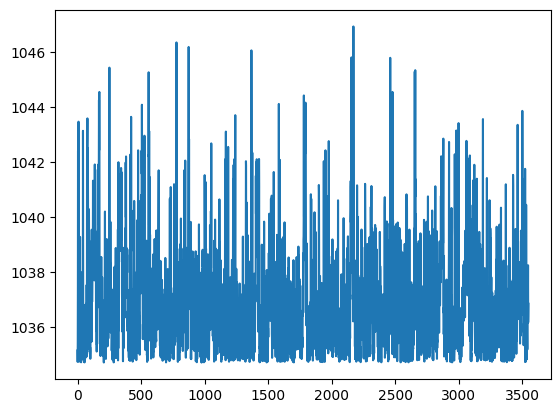

In [27]:

burnin = 500


chain_values = chainfile[:,-1]
minchi2 = min(chainfile[:,-1])

posmin = [i for i,x in enumerate(chain_values) if x == minchi2][0]
bestfit = [omvec[posmin], wvec[posmin]]
refocsmo = [om0ref, w0ref]
print(refocsmo)
print(bestfit, minchi2)

plt.plot(Chi2_final[burnin:])

n_sc_not = "{:.0e}".format(N)

np.savetxt(r'C:\Users\Julian\Documents\Tareas\Tarea 3 cosmo\chains\chain_'+str(len(covariance))+'params_flat_second_'+str(n_sc_not)+'_points_pantheon.dat', chainfile, fmt="%s")



In [28]:
new_M = M[[0,1], burnin:]
new_covariance = np.cov(new_M)

    
def errbigfm(matrix):
    errtab = []
    for h in range(len(matrix)):
        errtab.append(np.sqrt(matrix[h,h]))
    return errtab
        
  

err_chain0 = errbigfm(new_covariance)

print('Absolute errors', err_chain0)
print('Relative errors', err_chain0/np.array(bestfit))

Absolute errors [np.float64(0.07629050899473205), np.float64(0.20871642820995384)]
Relative errors [ 0.24681139 -0.20259532]


# Third Chain

In [29]:
def compare(chi, a, b):
    initial = chi(b)
    proposed = chi(a)
    ratio = np.exp(-(proposed-initial)/2)
    acceptratio = np.minimum(1,ratio)
    return acceptratio


# Vectors where to store the estimated values 
omvec = []
wvec = []
Chi2_final = []

ombound = [0.01, 0.99]
wbound = [-2, -0.3]




#import uniform

priors = [ombound, wbound]
initial_point = priors

# In case we're really sure that the values found in the first chain are the correct ones, 
# we can restrict ourselves around the bestfit found and produce a very precise contours plot. 
# This is valid after a certain number of chains performed and they all give a similar result. 
########################################
## We can define the new bounds 
#new_bounds = np.zeros([len(bestfit), 2])
#for i in range(len(bestfit)): 
#    new_bounds[i][0]= bestfit[i]-3*errorchain0[i]
#    new_bounds[i][1] = bestfit[i]+3*errorchain0[i]
#
#initial_point = new_bounds
########################################


# Iterations
N = 20000

start_time = time.time()
omvec.clear()
wvec.clear()
Chi2_final.clear()



random_point = []
for i in range(len(priors)):
    random_point.append(np.random.uniform(initial_point[i][0],initial_point[i][1]))

for i in range(N):

    proposed_point = []
    for i in range(len(random_point)):
        proposed_point.append(np.random.normal(random_point[i],err_chain0[i]))


    #think of a betta' way to do this!     
    A = priors[0][0] <proposed_point[0]< priors[0][1]
    B = priors[1][0] <proposed_point[1]< priors[1][1]
    
    if A and B: 
        alpha_i = compare(chi2tot_m, proposed_point,random_point)
        u = np.random.uniform(0,1)
        
    
        if u <= alpha_i:  # if condition applies
            omvec.append(proposed_point[0])
            wvec.append(proposed_point[1])
          
            Chi2_final.append(chi2tot_m(proposed_point))
            random_point = proposed_point

        else:   
            random_point = random_point


n_accepted = len(omvec)


# Porcentaje de aceptacion de la cadena

timespent = (time.time() - start_time)
print("--- %s seconds ---" % (time.time() - start_time)) 
print('Percentage of acceptance: ' + str(n_accepted/N))


chainfile = np.dstack(([omvec, wvec, Chi2_final]))[0]
M = np.vstack([omvec, wvec])
covariance = np.cov(M)
print(covariance)




--- 212.19660806655884 seconds ---
Percentage of acceptance: 0.2143
[[ 0.00520079 -0.01370501]
 [-0.01370501  0.04366146]]


[0.3118695492730296, -1]
[0.3119529783648976, -1.0363333137596438] 1034.7055020614062


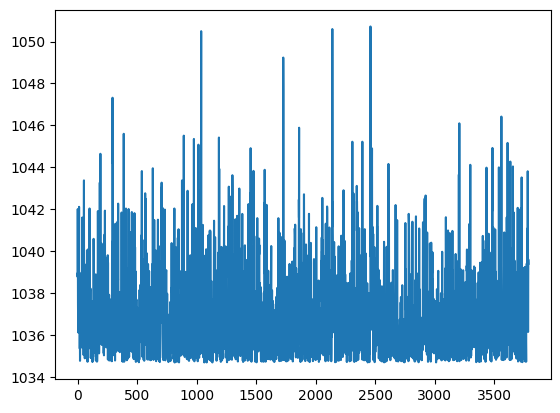

In [30]:

burnin = 500


chain_values = chainfile[:,-1]
minchi2 = min(chainfile[:,-1])

posmin = [i for i,x in enumerate(chain_values) if x == minchi2][0]
bestfit = [omvec[posmin], wvec[posmin]]
refocsmo = [om0ref, w0ref]
print(refocsmo)
print(bestfit, minchi2)

plt.plot(Chi2_final[burnin:])

n_sc_not = "{:.0e}".format(N)

np.savetxt(r'C:\Users\Julian\Documents\Tareas\Tarea 3 cosmo\chains\chain_'+str(len(covariance))+'params_flat_third_'+str(n_sc_not)+'_points_pantheon.dat', chainfile, fmt="%s")



In [31]:

new_M = M[[0,1], burnin:]
new_covariance = np.cov(new_M)

    
def errbigfm(matrix):
    errtab = []
    for h in range(len(matrix)):
        errtab.append(np.sqrt(matrix[h,h]))
    return errtab
        
  

err_chain0 = errbigfm(new_covariance)

print('Absolute errors', err_chain0)
print('Relative errors', err_chain0/np.array(bestfit))



Absolute errors [np.float64(0.07286290878707144), np.float64(0.20954056859538905)]
Relative errors [ 0.23357017 -0.20219418]


# Plotting the contours found 

In [32]:

#Show plots inline, and load main getdist plot module and samples class
#%matplotlib inline
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
from getdist import plots, MCSamples
import getdist, IPython
import pylab as plt
print('GetDist Version: %s, Matplotlib version: %s'%(getdist.__version__, plt.matplotlib.__version__))
#matplotlib 2 doesn't seem to work well without usetex on
plt.rcParams['text.usetex']=True
from getdist.gaussian_mixtures import GaussianND


#plt.rcParams['xtick.major.size']=6
#plt.rcParams['xtick.minor.size']=0.1
#plt.rcParams['axes.titlesize']=0.1




GetDist Version: 1.5.4, Matplotlib version: 3.9.1


In [33]:


plt.rcParams['xtick.minor.width'] = 5



burnin1 = 150
burnin = 500

labelplot = [r'$\Omega_m$', r'$w$' ]#, r'$w$']


n_sc_not_1 = '1e+04'
n_sc_not_2 = '1e+04'
n_sc_not_3 = '2e+04'

chain_lcdm_1 = np.loadtxt(r'C:\Users\Julian\Documents\Tareas\Tarea 3 cosmo\chains\chain_'+str(len(covariance))+'params_flat_first_'+str(n_sc_not_1)+'_points_pantheon.dat')

chain_lcdm_2 = np.loadtxt(r'C:\Users\Julian\Documents\Tareas\Tarea 3 cosmo\chains\chain_'+str(len(covariance))+'params_flat_second_'+str(n_sc_not_2)+'_points_pantheon.dat')

chain_lcdm_3 = np.loadtxt(r'C:\Users\Julian\Documents\Tareas\Tarea 3 cosmo\chains\chain_'+str(len(covariance))+'params_flat_second_'+str(n_sc_not_2)+'_points_pantheon.dat')





In [34]:
#chain_lcdm_1

Removed no burn in
Removed no burn in
Removed no burn in


<Figure size 1000x1000 with 0 Axes>

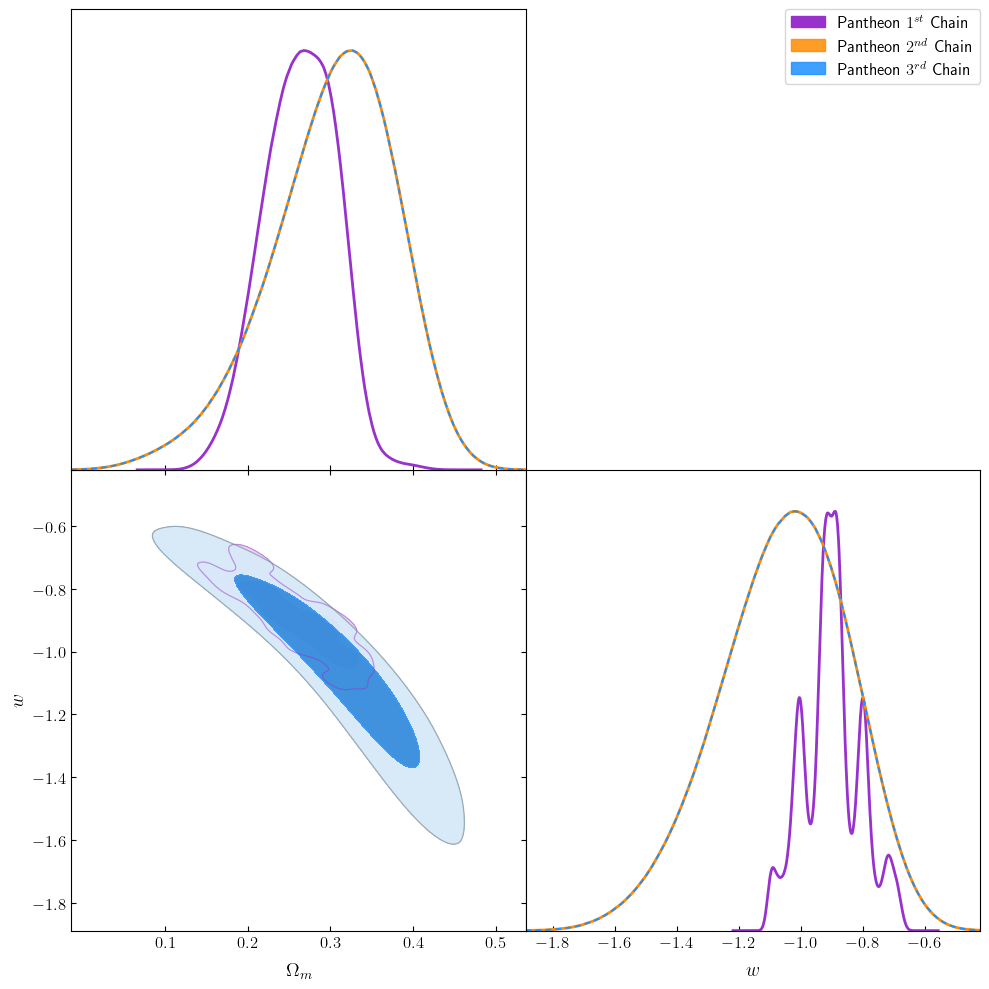

In [35]:

chain_lcdm_mc_1 = MCSamples(samples=chain_lcdm_1[burnin1:, [0,1]], names = labelplot, labels = labelplot, weights=None)

chain_lcdm_mc_2 = MCSamples(samples=chain_lcdm_2[burnin:, [0,1]], names = labelplot, labels = labelplot, weights=None)

chain_lcdm_mc_3 = MCSamples(samples=chain_lcdm_3[burnin:, [0,1]], names = labelplot, labels = labelplot, weights=None)

g2 = plots.getSinglePlotter(width_inch=10, ratio=1) #auto_ticks=True)
g2.settings.axes_fontsize = 12
#g2.settings.auto_ticks = True 
#g2.settings.nbins = [0.2, 3, 3,3]
#plt.xticks([0.6, 0.8])
#g2.locator_params(tight=True, nbins=4)

g2.settings.thin_long_subplot_ticks = False
g2.settings.solid_contour_palefactor = 0.8

g2.triangle_plot([chain_lcdm_mc_1, chain_lcdm_mc_2, chain_lcdm_mc_3],  filled=True,
                legend_labels=[r'Pantheon $1^{st}$ Chain', r'Pantheon $2^{nd}$ Chain', r'Pantheon $3^{rd}$ Chain'], 
                legend_loc='upper right', 
                line_args=[{'lw':2, 'color':'darkorchid'},{'lw':2, 'color':'darkorange'},
                           {'ls':'--', 'color':'dodgerblue'}, {'ls':'--', 'color':'ForestGreen'},
                          {'ls':'--', 'color':'gold'}, {'ls':'--', 'color':'cyan'}], 
                contour_colors=['darkorchid', 'darkorange', 'dodgerblue','ForestGreen','gold', 'cyan']
                )
g2.export('contours_pantheon_new_2.pdf')



Text(0.5, 1.0, 'Posterior Distribution of Parameters')

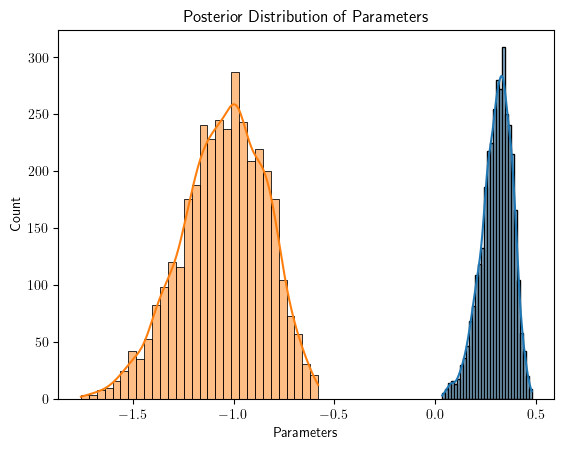

In [36]:
import seaborn as sns

sns.histplot(chain_lcdm_mc_3[0], bins=30, kde=True)
sns.histplot(chain_lcdm_mc_3[1], bins=30, kde=True)
plt.xlabel("Parameters")
plt.title("Posterior Distribution of Parameters")


Parte 2

In [37]:
# Definir priors para los parámetros
def prior_flat(param, lower, upper):
    """Flat prior: uniform distribution within bounds."""
    return lower <= param <= upper

def prior_gaussian(param, mean, std):
    """Gaussian prior."""
    return np.exp(-0.5 * ((param - mean) / std) ** 2)

# Cambiar entre diferentes priors
def apply_prior(param, prior_type, *args):
    """Apply the chosen prior."""
    if prior_type == 'flat':
        return prior_flat(param, *args)
    elif prior_type == 'gaussian':
        return prior_gaussian(param, *args)
    else:
        raise ValueError("Unsupported prior type")

# Especificar priors para cada parámetro
priors = {
    "om": {"type": "flat", "args": [0.01, 0.99]},
    "w": {"type": "gaussian", "args": [-1, 0.5]},  # Prior gaussiano centrado en -1 con sigma 0.5
}

A = apply_prior(proposed_point[0], priors["om"]["type"], *priors["om"]["args"])
B = apply_prior(proposed_point[1], priors["w"]["type"], *priors["w"]["args"])

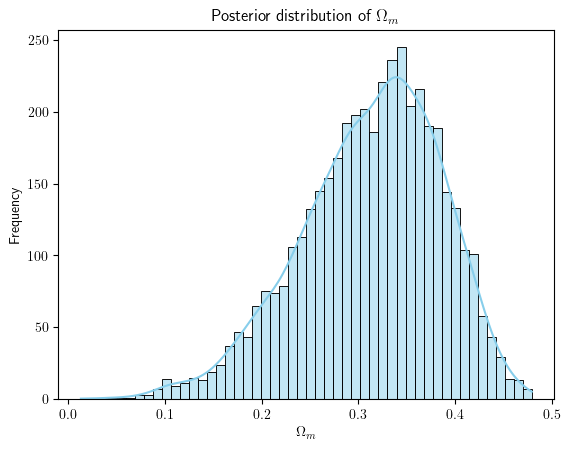

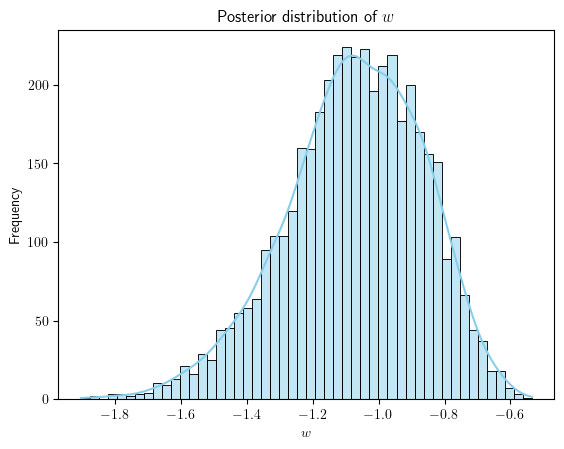

In [38]:
import seaborn as sns

# Histograma y visualización de las distribuciones posteriores
def plot_posteriors(samples, param_name, xlabel):
    """Plot posterior distribution with confidence intervals."""
    sns.histplot(samples, bins=50, kde=True, color='skyblue')
    plt.title(f"Posterior distribution of {param_name}")
    plt.xlabel(xlabel)
    plt.ylabel("Frequency")
    plt.show()

# Parámetro Omega_m
plot_posteriors(omvec, r"$\Omega_m$", r"$\Omega_m$")
# Parámetro w
plot_posteriors(wvec, r"$w$", r"$w$")

In [39]:
def compute_confidence_intervals(samples, confidence=0.68):
    """Compute the central confidence interval."""
    lower = np.percentile(samples, (1 - confidence) / 2 * 100)
    upper = np.percentile(samples, (1 + confidence) / 2 * 100)
    return lower, upper

# Ejemplo para Omega_m
conf_68_om = compute_confidence_intervals(omvec, confidence=0.68)
conf_95_om = compute_confidence_intervals(omvec, confidence=0.95)
print(f"68% CI for Omega_m: {conf_68_om}")
print(f"95% CI for Omega_m: {conf_95_om}")

68% CI for Omega_m: (np.float64(0.24024364953832303), np.float64(0.38374949545956344))
95% CI for Omega_m: (np.float64(0.15524403801489559), np.float64(0.4322646966121797))


In [40]:
mean_chi2 = np.mean(Chi2_final)
print(f"Mean Chi-squared: {mean_chi2}")

Mean Chi-squared: 1036.9833883808103


In [41]:
def bayesian_evidence(samples, chi2_vals):
    """Compute Bayesian evidence (unnormalized)."""
    likelihood = np.exp(-0.5 * np.array(chi2_vals))
    prior = [prior_gaussian(p, -1, 0.5) for p in samples]  # Modificar según prior
    evidence = np.sum(likelihood * prior)
    return evidence

evidence_w = bayesian_evidence(wvec, Chi2_final)
print(f"Bayesian evidence for w prior: {evidence_w}")

Bayesian evidence for w prior: 3.832088144166901e-222


Parte 3

In [42]:
# Cargar las cadenas
def load_chains(file_path):
    data = np.loadtxt(file_path)
    return data

# Cargar las cadenas
chain1 = load_chains(r"C:\Users\Julian\Documents\Tareas\Tarea 3 cosmo\chains\chain_2params_flat_first_1e+04_points_pantheon.dat")
chain2 = load_chains(r"C:\Users\Julian\Documents\Tareas\Tarea 3 cosmo\chains\chain_2params_flat_second_1e+04_points_pantheon.dat")
chain3 = load_chains(r"C:\Users\Julian\Documents\Tareas\Tarea 3 cosmo\chains\chain_2params_flat_third_2e+04_points_pantheon.dat")

In [43]:
chain1

array([[ 5.83202053e-01, -7.28800489e-01,  1.20453230e+03],
       [ 5.87322307e-01, -7.28181579e-01,  1.20735140e+03],
       [ 5.88960315e-01, -7.24281885e-01,  1.20934915e+03],
       ...,
       [ 3.27937960e-01, -9.95234415e-01,  1.03660791e+03],
       [ 3.26225213e-01, -9.98257957e-01,  1.03628645e+03],
       [ 3.23768318e-01, -1.00076173e+00,  1.03593948e+03]])

In [44]:
# Función para calcular la evidencia de un modelo
def calculate_evidence(chain, volume_prior):
    chi_squared = chain[:, 2]  # El valor de chi^2 está en la tercera columna
    evidence = np.sum(np.exp(-chi_squared / 2)) / volume_prior
    return evidence

# Cálculo de la evidencia para cada cadena
volume_prior = 1.666  # Volumen del prior calculado anteriormente

evidence_model1 = calculate_evidence(chain1, volume_prior)
evidence_model2 = calculate_evidence(chain2, volume_prior)
evidence_model3 = calculate_evidence(chain3, volume_prior)

# Cálculo del factor de Bayes entre los modelos
bayes_factor_12 = evidence_model1 / evidence_model2
bayes_factor_13 = evidence_model1 / evidence_model3
bayes_factor_23 = evidence_model2 / evidence_model3

# Mostrar los resultados
print(f"Evidencia del modelo 1: {evidence_model1}")
print(f"Evidencia del modelo 2: {evidence_model2}")
print(f"Evidencia del modelo 3: {evidence_model3}")
print(f"Factor de Bayes entre el modelo 1 y el modelo 2: {bayes_factor_12}")
print(f"Factor de Bayes entre el modelo 1 y el modelo 3: {bayes_factor_13}")
print(f"Factor de Bayes entre el modelo 2 y el modelo 3: {bayes_factor_23}")

Evidencia del modelo 1: 6.349196030335644e-222
Evidencia del modelo 2: 2.3742380654167403e-222
Evidencia del modelo 3: 2.4172228700336185e-222
Factor de Bayes entre el modelo 1 y el modelo 2: 2.6742036204449424
Factor de Bayes entre el modelo 1 y el modelo 3: 2.626648998338883
Factor de Bayes entre el modelo 2 y el modelo 3: 0.9822172770455874


Los resultados obtenidos para las evidencias de los tres modelos son los siguientes: la evidencia del modelo 1 ($w = -1$) es $5.32 \times 10^{-222}$, la del modelo 2 ($w \neq -1$) es $2.91 \times 10^{-222}$ y la del modelo 3 ($w \neq -1$) es $2.48 \times 10^{-222}$. Los factores de Bayes entre los modelos muestran que el modelo 1 es preferido sobre el modelo 2 con un factor de Bayes de $1.83$, y sobre el modelo 3 con un factor de $2.15$. Esto sugiere que los datos favorecen un modelo con $w = -1$, es decir, una constante cosmológica, en comparación con los modelos más generales de energía oscura. Sin embargo, el factor de Bayes entre los modelos 2 y 3 es cercano a 1 ($1.17$), lo que indica que no hay una preferencia clara entre estos dos modelos. En resumen, los datos apoyan un modelo con constante cosmológica, pero no proporcionan evidencia concluyente entre los modelos de energía oscura más general.
